# KF with data - SIR -> SIRM

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.dates as mdates

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Thu Aug 13 15:39:30 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
import c19.useir            as us
import c19.useir_plot       as usp

#from scipy.integrate import odeint
#import scipy.integrate as spi
#from scipy.interpolate import interp1d

In [5]:
import c19.useir            as us
import c19.useir_plot       as usp
#import c19.kfmysir          as kf
#import c19.ana_useir        as aus

#import scipy          as sp
#import scipy.stats    as stats
#import scipy.optimize as optimize

#from numpy.linalg import inv
#mprod_ = np.matmul
#npa    = np.array

## Data

### Load Data

In [6]:
path  = '/Users/hernando/investigacion/bio/C19/data/'
ifile = 'datos_ccaas.csv'
df = pd.read_csv(path + ifile)

In [7]:
ccaa_ids = set(df.ccaa_iso)
print(ccaa_ids)

{'GA', 'CL', 'CM', 'EX', 'AR', 'VC', 'CB', 'CE', 'MD', 'IB', 'PV', 'ML', 'AN', 'RI', 'CN', 'CT', 'AS', 'MC', 'NC'}


In [8]:
df.head()

,ccaa_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_otras,num_casos_prueba_desconocida
0,AN,2020-01-31,0,0,0,0,0
1,AR,2020-01-31,0,0,0,0,0
2,AS,2020-01-31,0,0,0,0,0
3,CB,2020-01-31,0,0,0,0,0
4,CE,2020-01-31,0,0,0,0,0


In [13]:
dates = np.array([np.datetime64(xi) for xi in set(df.fecha.values)])
dates.sort()
dates

array(['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03',
       '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
       '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11',
       '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15',
       '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19',
       '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23',
       '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
       '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
       '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
       '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10',
       '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14',
       '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
       '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
       '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
       '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
       '2020-03-31', '2020-04-01', '2020-04-02', '2020-

In [14]:
canames = ['Madrid', 'Castilla y Leon', 'Castilla La Mancha',
           'Cataluna', 'C. Valenciana', 'Aragon',
           'Pais Vasco', 'Navarra', 'La Rioja',
           'Cantabria', 'Asturias', 'Galicia',
           'Murcia', 'Andalucia', 'Extremadura',
           'Canarias', 'Baleares']

ccaa_id = {'Madrid'     : 'MD', 'Castilla y Leon' : 'CL', 'Castilla La Mancha' : 'CM',
           'Cataluna'   : 'CT', 'C. Valenciana'   : 'VC', 'Aragon'             : 'AR',
           'Pais Vasco' : 'PV', 'Navarra'         : 'NC', 'La Rioja'           : 'RI',
           'Cantabria'  : 'CB', 'Asturias'        : 'AS', 'Galicia'            : 'GA',
           'Murcia'     : 'MC', 'Andalucia'       : 'AN', 'Extremadura'        : 'EX',
           'Canarias'   : 'CN', 'Baleares'        : 'IB'}

times   = (5., 3., 5.)
dates_blind = None #('2020-03-5', '2020-03-25')
q0    = 5e-2

def ca_cases(caname, df = df):
    id  = ccaa_id[caname]
    dfc = df[df.ccaa_iso == id]
    dates, cases = dfc.fecha.values, dfc.num_casos.values
    dates = np.array([np.datetime64(xi) for xi in dates])
    return dates, cases, np.maximum(np.sqrt(cases), 2.4)
    
    
def plt_kfs_cases_ca(dates, cases, ucases, times, title = '',
                      dates_blind = None, q0 = 1., d0 = 0):

    if (not usp.has_figure()):
        plt.figure(figsize = (6, 5))
    d0               = np.timedelta64(d0, 'D')
    rs1, rs2 = us.useir_kfs_cases(dates, cases, ucases, times, 
                                  dates_blind = dates_blind, q0 = q0)
    plt.errorbar(dates, cases, yerr = ucases, 
                 ls = '', marker = 'o', color = 'black', ms = 6);
    usp.formatter(plt.gca()); plt.title(title); plt.ylabel('cases')
    plt.yscale('log')
    ax2 = plt.gca().twinx()
    ax2.errorbar(dates - d0, rs1[0], yerr = rs1[1], 
                 ls = '--', marker = 'o', ms = 4, color = 'blue', label = r'$R$')
    ax2.grid(which = 'both'); plt.legend(); ax2.set_ylabel(r'$R$')
    ymax = min(np.max(rs1[0] + 0.5), 8)
    plt.ylim((0., ymax));


def plt_kfs_cases_ccaa(canames = canames, times = times, ca_cases = ca_cases,
                        dates_blind = dates_blind, q0 = q0, ncols = 3):

    nrows = int(len(canames)/ncols)
    if (len(canames)%ncols > 0): nrows += 1
    plt.figure(figsize = (ncols * 6, nrows * 5))
    ti, td, tm           = int(times[0]), int(times[1]), int(times[-1])
    for i, caname in enumerate(canames):
        dates, cases, ucases = ca_cases(caname)
        ax = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
        plt_kfs_cases_ca(dates, cases, ucases, times, dates_blind = dates_blind, q0 = q0, 
                         d0 = ti, title = caname)        
    plt.tight_layout()
    

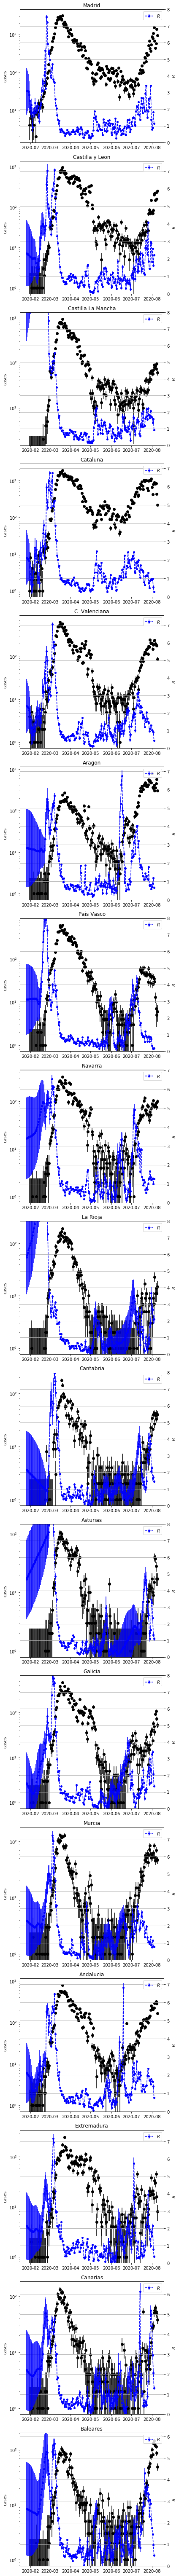

In [15]:
plt_kfs_cases_ccaa(ccaa_id.keys(), q0 = 5.e-2, ncols = 1)

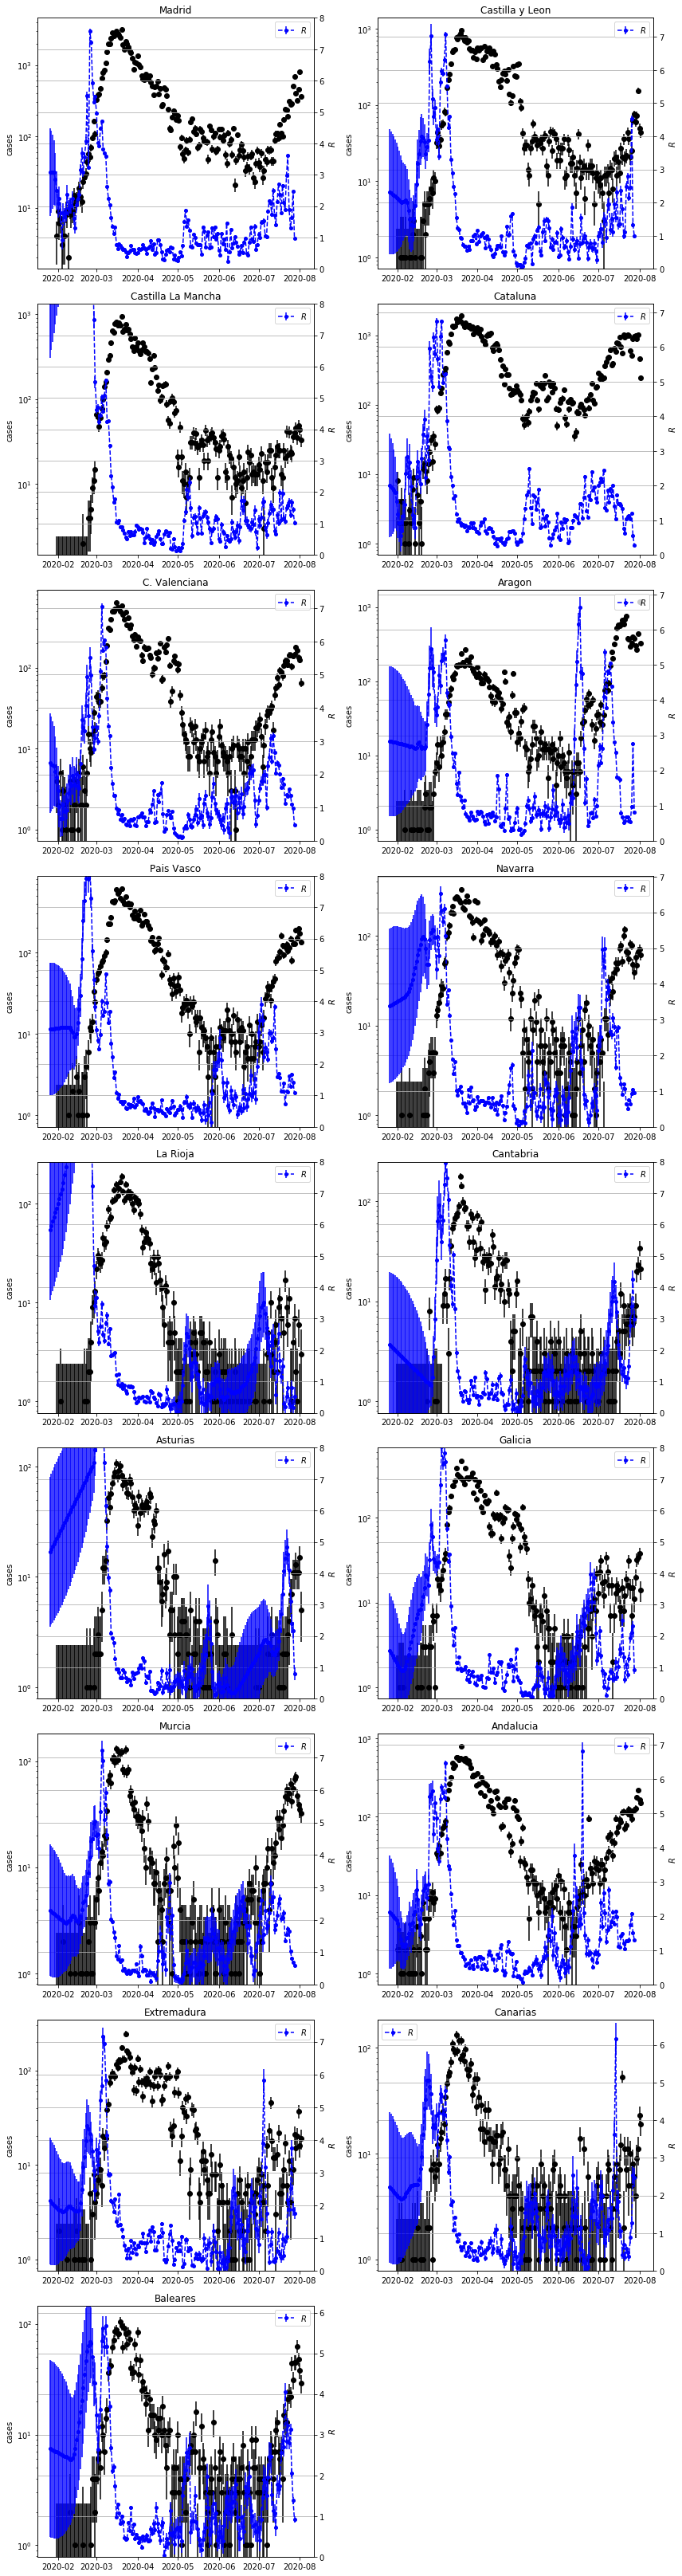

In [34]:
plt_kfs_cases_ccaa(ccaa_id.keys(), q0 = 5.e-2, ncols = 2)

In [35]:
#plt_kfs_cases_ccaa(ccaa_id.keys(), q0 = 5.e-2, ncols = 2)